In [1]:
import numpy as np
import astropy.io.fits as fits 
import matplotlib.pyplot as plt
from scipy import ndimage
import random
from scipy.optimize import leastsq
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from musepy import *
from astropy.io import fits
from astropy.wcs import WCS
import astropy.constants as const
import astropy.units as u
from astropy.visualization import astropy_mpl_style

import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

### This is magic for Jupyer Notebooks. 
### Delete if putting into a script!
%matplotlib inline 
#######################################

import imageio

In [2]:
hdu = fits.open('HE0232-0900.wo_absorption.fits')
#hdu.info()
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
wavstart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
wave = wavstart+np.arange(qso_data.shape[0])*wavint  #. This is the same as the one below. 
[central_x,central_y]= [67,51]#

In [3]:
z =0.043143 
k = 1+z

In [4]:
mini_data = qso_data[:,central_y - 27:central_y + 28,central_x - 27:central_x + 28]
mini_error = qso_error[:,central_y - 27:central_y + 28,central_x - 27:central_x + 28]
qso_header['CRPIX1'] = qso_header['CRPIX1'] - (central_x - 27)
qso_header['CRPIX2'] = qso_header['CRPIX2'] - (central_y - 27)
new_hdu = fits.HDUList([fits.PrimaryHDU(mini_data),fits.ImageHDU(mini_error)])
new_hdu[0].header = qso_header
wave = np.arange(wavstart,(wavstart+(wavint*mini_data.shape[0])))

In [5]:
w80 = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
vel_diff = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
F_nr = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
F_br = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
flux_total = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
v5 = np.zeros((mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)

In [6]:
np.seterr(divide='ignore', invalid='ignore')
for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        spectrum = mini_data[:,i,j]
        wave = np.arange(wavstart,(wavstart+(wavint*mini_data.shape[0])),wavint)
        select = (wave > 4750*k) & (wave < 5090*k) 
        n = len(wave[select])
        mean = sum(wave[select]*spectrum[select])/n
        sigma = sum(spectrum[select]*(wave[select]-mean)**2)/n  
        
        x = wave[select]
        y = spectrum[select]
        y_err = mini_error[:,i,j][select]
        
        if np.min(y/y_err) > 0:
                popt2,pcov2 = leastsq(full_gauss2,x0=[2,40,12942,50.0,5,5,12842,100.0,5,1,12942,1000.0,1,1,12942,1000.0,-0.001,0.1],args=(x,y,y_err),maxfev=100000000)
                
               # plt.plot(x,y)
                fit = full_gauss2(popt2,x,y,y_err)*(y_err)+y
               # plt.plot(x,fit,'r-',label='fit')
               # plt.show()
                
                (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c)=popt2
                cor_popt2 = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
                
                c = 3*(10**5)
                (wav_min,wav_max)=(4967*k,5037*k)
                wave = np.arange(wav_min,wav_max,0.02) 
                cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt2))
                norm_sum=cumsum/cumsum[-1]
    
                select = (norm_sum>0.1) & (norm_sum<0.9)
                w80_spec = wave[select][-1]-wave[select][0]
                   
                select =  (norm_sum>0.05) & (norm_sum<0.5)
                v5_spec = wave[select][0]-wave[select][-1]

                w80[i,j]=((w80_spec)/5006.8)*(c/(1+z))
                if w80[i,j]>3000: #>1000:
                    w80[i,j]=0
                else:
                    w80[i,j] = w80[i,j]
                v5[i,j] = ((v5_spec)/5006.8)*(c/(1+z))
                
                sigma_OIII_5007_br = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0) 
                flux_br = amp_OIII5007_br*(np.sqrt(2.*np.pi)*np.fabs(sigma_OIII_5007_br)) 

                sigma_OIII_5007 = line_width_recons(vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0) 
                flux_nr = amp_OIII5007*(np.sqrt(2.*np.pi)*np.fabs(sigma_OIII_5007)) 
                F_br[i,j] = flux_br
                if F_br[i,j] >0:
                    F_br[i,j] = F_br[i,j]
                else:
                    F_br[i,j] = 0
                    
                F_nr[i,j] = flux_nr
                if F_nr[i,j] >0:
                    F_nr[i,j] = F_nr[i,j]
                else:
                    F_nr[i,j] = 0  
                
                flux_total[i,j] =  flux_br+flux_nr
                
                if flux_total[i,j] >0:
                    flux_total[i,j] = flux_total[i,j] 
                else:
                    flux_total[i,j] = 0
                
                velshift_actual = (cor_popt2[2]-cor_popt2[4])
                
                vel_diff[i,j] = velshift_actual 
                
                if (vel_diff[i,j]>0):# & (vel_diff[i,j]<2000):
                    vel_diff[i,j]= vel_diff[i,j]
                else:
                    vel_diff[i,j] = 0
                    
                print('velocity shift is', vel_diff[i,j])
                print('w80',w80[i,j])
                print('v5',v5[i,j])
                                                              
        else:
             exit

('velocity shift is', 83.491844)
('w80', 256.18402)
('v5', -150.49374)
('velocity shift is', 80.226944)
('w80', 263.07684)
('v5', -156.23778)
('velocity shift is', 72.886314)
('w80', 288.35062)
('v5', -163.13063)
('velocity shift is', 84.17079)
('w80', 295.24347)
('v5', -173.4699)
('velocity shift is', 70.06682)
('w80', 310.17795)
('v5', -184.95796)
('velocity shift is', 109.353935)
('w80', 315.922)
('v5', -195.29723)
('velocity shift is', 68.80241)
('w80', 238.9519)
('v5', -141.30328)
('velocity shift is', 66.2799)
('w80', 240.10071)
('v5', -145.89851)
('velocity shift is', 78.30588)
('w80', 240.10071)
('v5', -145.89851)
('velocity shift is', 73.79768)
('w80', 253.8864)
('v5', -153.94017)
('velocity shift is', 62.27043)
('w80', 269.9697)
('v5', -157.3866)
('velocity shift is', 79.8806)
('w80', 276.86255)
('v5', -165.42824)
('velocity shift is', 71.14239)
('w80', 298.68988)
('v5', -178.06512)
('velocity shift is', 84.28431)
('w80', 321.66602)
('v5', -191.8508)
('velocity shift is', 113

('velocity shift is', 54.070328)
('w80', 357.27905)
('v5', -182.66035)
('velocity shift is', 75.19907)
('w80', 420.46344)
('v5', -230.91025)
('velocity shift is', 78.5461)
('w80', 404.38016)
('v5', -243.54713)
('velocity shift is', 141.21375)
('w80', 472.15976)
('v5', -303.2851)
('velocity shift is', 76.86938)
('w80', 525.0049)
('v5', -388.29684)
('velocity shift is', 82.6515)
('w80', 542.237)
('v5', -403.23132)
('velocity shift is', 80.049904)
('w80', 565.21313)
('v5', -419.31464)
('velocity shift is', 74.6936)
('w80', 582.44525)
('v5', -433.1003)
('velocity shift is', 75.349434)
('w80', 574.4036)
('v5', -427.3563)
('velocity shift is', 78.49796)
('w80', 559.4691)
('v5', -408.97537)
('velocity shift is', 72.83266)
('w80', 569.8084)
('v5', -421.61224)
('velocity shift is', 48.092926)
('w80', 595.08215)
('v5', -429.6539)
('velocity shift is', 141.70775)
('w80', 533.0466)
('v5', -390.59445)
('velocity shift is', 0.0)
('w80', 502.02875)
('v5', -303.2851)
('velocity shift is', 66.36705)
('

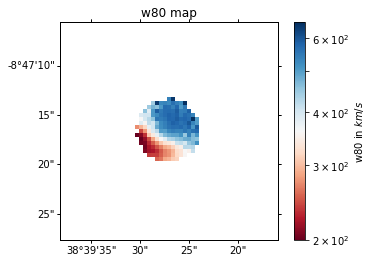

In [7]:
from matplotlib.colors import LogNorm
from matplotlib import cm

my_wcs = WCS(qso_header).celestial

ax = plt.subplot(projection=my_wcs)
cmap=cm.gray
plt.imshow(w80,origin='lower',interpolation='nearest',norm=LogNorm(),cmap='RdBu')
plt.title(r"w80 map",fontsize= 12)
cbar = plt.colorbar()
cbar.set_label("w80 in $km/s$")
cmap.set_bad('black',1)
plt.show()

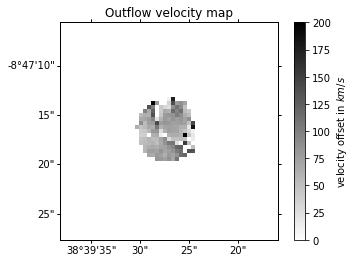

In [45]:
my_wcs = WCS(qso_header).celestial

ax = plt.subplot(projection=my_wcs)

plt.imshow(vel_diff,origin='lower', cmap='binary',vmin=0,vmax=200,interpolation='nearest')
cmap.set_bad('black',1)
plt.title(r"Outflow velocity map",fontsize= 12)
cbar = plt.colorbar()
cbar.set_label("velocity offset in $km/s$")
cmap.set_bad('green',1)
plt.show()
plt.show()

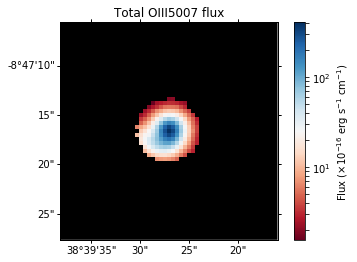

In [50]:

my_wcs = WCS(qso_header).celestial

ax = plt.subplot(projection=my_wcs)

plt.imshow(flux_total,origin='lower', cmap='RdBu',norm=LogNorm(), interpolation='nearest')
cmap.set_bad('black',1)
plt.title(r"Total OIII5007 flux",fontsize= 12)
cbar = plt.colorbar()
cbar.set_label(r"Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-1}$)")
cmap.set_bad('black',1)
plt.show()
plt.show()

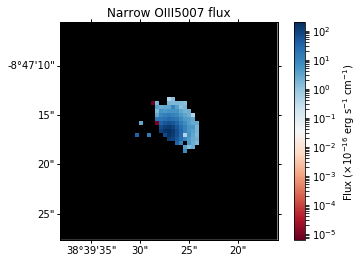

In [24]:
my_wcs = WCS(qso_header).celestial

ax = plt.subplot(projection=my_wcs)

plt.imshow(F_nr,origin='lower', cmap='RdBu',norm=LogNorm(), interpolation='nearest')
cmap.set_bad('black',1)
plt.title(r"Narrow OIII5007 flux",fontsize= 12)
cbar = plt.colorbar()
cbar.set_label(r"Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-1}$)")
cmap.set_bad('black',1)
plt.show()


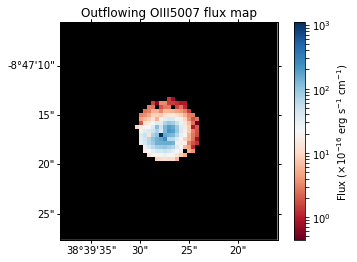

In [22]:
my_wcs = WCS(qso_header).celestial

ax = plt.subplot(projection=my_wcs)

plt.imshow(F_br,origin='lower', cmap='RdBu',norm=LogNorm(), interpolation='nearest')
cmap.set_bad('black',1)
plt.title(r"Outflowing OIII5007 flux map",fontsize= 12)
cbar = plt.colorbar()
cbar.set_label(r"Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-1}$)")
cmap.set_bad('black',1)
plt.show()
